In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0,  EfficientNetB3, ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, ReLU, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os

import seaborn as sns
import random
import time


In [11]:
# Для воспроизводимости результатов
random_seed = 42

random.seed(random_seed)
np.random.seed(random_seed)

In [43]:
print('Ведите название модели')
NAME_MODEL = input()
print('Использовать аугментацию (y/n)')
x = input()
AUGMENTATION = x=='y'

EPOCHS = 50 # Для предобученных 25-50, Для своей - 150-200
if NAME_MODEL=='EfficientB3':
    HEIGHT=300 # Должно соответствовать размеру входного слоя 
    WIDTH=300  # Должно соответствовать размеру входного слоя
elif NAME_MODEL=='CNN':
    HEIGHT=150 # Должно соответствовать размеру входного слоя 
    WIDTH=150  # Должно соответствовать размеру входного слоя
    EPOCHS=150
else:
    HEIGHT=224 # Должно соответствовать размеру входного слоя 
    WIDTH=224  # Должно соответствовать размеру входного слоя
TARGET_SIZE = (HEIGHT, WIDTH)
BATCH_SIZE = 64 
CLASS_MODE = 'binary'

if AUGMENTATION:
    FILE_BEST_MODEL = 'best_model_'+NAME_MODEL+'.keras'
else:
    FILE_BEST_MODEL = 'best_model_'+NAME_MODEL+'_without_augmentation.keras'


In [4]:
# Пути к данным
dir_train = os.path.join('Worksite-Safety-Monitoring-Dataset', 'train') 
dir_test = os.path.join('Worksite-Safety-Monitoring-Dataset', 'test')  
dir_val = os.path.join('Worksite-Safety-Monitoring-Dataset', 'valid') 

In [5]:
# Аугментация данных
if AUGMENTATION:
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
else:
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # Если без аугментации

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Генераторы данных
train_generator = train_datagen.flow_from_directory(
    dir_train,
    target_size=TARGET_SIZE,  
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['safe', 'unsafe'],  # 0: safe, 1: unsafe
    color_mode='rgb'
)

val_generator = val_datagen.flow_from_directory(
    dir_val,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['safe', 'unsafe'],
    color_mode='rgb'
)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Примеры исходных изображений


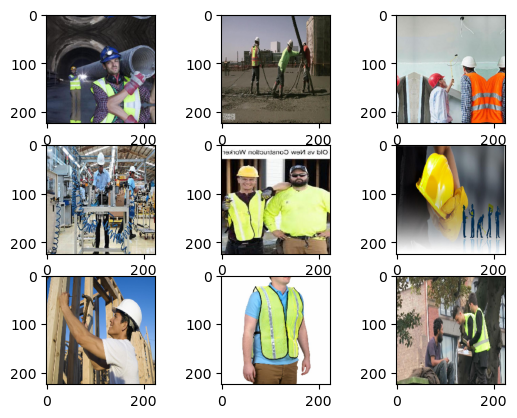

In [7]:
if AUGMENTATION:
    # Визуализация аугментации
    print("Примеры аугментированных изображений")
else:
    print("Примеры исходных изображений")
for X_batch, y_batch in train_generator:
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(X_batch[i]/255.0)
    plt.show()
    break


In [ ]:
# Создание модели CNN 
def create_CNN_model():
    model = Sequential([
        # Блок 1 (150x150 -> 75x75)
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        # Блок 2 (75x75 -> 37x37)
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        # Блок 3 (37x37 -> 18x18)
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Блок 4 (18x18 -> 9x9)
        #Conv2D(128, (3, 3), activation='relu', padding='same'),
        #BatchNormalization(),
        #MaxPooling2D((2, 2)),
        
        # Классификатор
        Flatten(),  # После этого будет 128*9*9 = 10368 элементов
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
   
    return model

In [ ]:
# Создание модели с Transfer Learning 
# Создание модели ResNet50 с Transfer Learning 
def create_ResNet50_model():
    # Загрузка предобученной ResNet50
    base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))
    
    # Замораживаем слои ResNet50
    for layer in base_model.layers:
        layer.trainable = False
    '''
    # Замораживаем все слои, кроме последних 4
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Размораживаем последние 4 слоя
    for layer in base_model.layers[-4:]:
        layer.trainable = True
    '''
    # Добавляем свои слои
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Бинарная классификация
    
    # Собираем модель
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [8]:
# Создание модели с Transfer Learning 
# Создание модели VGG с Transfer Learning 
def create_VGG16_model():
    # Загрузка предобученной VGG16
    base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))
    
    # Замораживаем слои VGG
    for layer in base_model.layers:
        layer.trainable = False
    '''
    # Замораживаем все слои, кроме последних 4
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Размораживаем последние 4 слоя
    for layer in base_model.layers[-4:]:
        layer.trainable = True
    '''
    # Добавляем свои слои
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Бинарная классификация
    
    # Собираем модель
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

model = create_vgg_model()
model.compile(optimizer=Adam(learning_rate=1e-4), # model.compile(optimizer=RMSprop(learning_rate=1e-5)
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Создание модели EfficientNetB0 с Transfer Learning 
def create_EfficientB0_model():
    # Загрузка предобученной EfficientNetB0 без верхних слоев
    base_model = EfficientNetB0(weights='imagenet', 
                      include_top=False, 
                      input_shape=(224, 224, 3))
    
    # Замораживаем слои EfficientNetB0
    for layer in base_model.layers:
        layer.trainable = False
    '''
    # Замораживаем все слои, кроме последних 4
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Размораживаем последние 4 слоя
    for layer in base_model.layers[-4:]:
        layer.trainable = True
    '''
    # Добавляем свои слои
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Бинарная классификация
    
    # Собираем модель
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [ ]:
# Создание модели EfficientNetB3 с Transfer Learning 
def create_EfficientB3_model():
    # Загрузка предобученной EfficientNetB3 без верхних слоев
    base_model = EfficientNetB3(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))
    
    # Замораживаем слои EfficientNetB3
    for layer in base_model.layers:
        layer.trainable = False
    '''
    # Замораживаем все слои, кроме последних 4
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Размораживаем последние 4 слоя
    for layer in base_model.layers[-4:]:
        layer.trainable = True
    '''
    # Добавляем свои слои
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Бинарная классификация
    
    # Собираем модель
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model


In [ ]:
if NAME_MODEL == 'CNN':
    model = create_CNN_model()
elif NAME_MODEL == 'ResNet50':
    model = create_ResNet50_model()
elif NAME_MODEL == 'VGG16':
    model = create_VGG16_model()
elif NAME_MODEL == 'EfficientB0':
    model = create_EfficientB0_model()
elif NAME_MODEL == 'EfficientB3':
    model = create_EfficientB3_model()

In [ ]:
# Компиляция модели
model.compile(optimizer=Adam(learning_rate=1e-4), # model.compile(optimizer=RMSprop(learning_rate=1e-5)
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


In [9]:
# Обучение модели
callbacks = [
    #EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(FILE_BEST_MODEL, monitor='val_accuracy', save_best_only=True)
]
start = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
print(f"Time training: {time.time()-start}")
# Сохранение модели
model.save(FILE_BEST_MODEL)

C:\Users\Mi\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.5776 - loss: 9.7007 - val_accuracy: 0.6458 - val_loss: 4.1673
Epoch 2/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:04 3s/step - accuracy: 0.6875 - loss: 4.3290

C:\Users\Mi\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 387ms/step - accuracy: 0.6875 - loss: 4.3290 - val_accuracy: 0.6615 - val_loss: 3.9905
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.8369 - loss: 1.9783 - val_accuracy: 0.7083 - val_loss: 2.9005
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.9062 - loss: 0.9707 - val_accuracy: 0.7188 - val_loss: 2.9052
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9380 - loss: 0.4535 - val_accuracy: 0.7083 - val_loss: 2.5060
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 384ms/step - accuracy: 0.8906 - loss: 0.8298 - val_accuracy: 0.7240 - val_loss: 2.3703
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9529 - loss: 0.3202 - val_accuracy: 0.6875 - val_loss: 2.5912
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.9531 - loss: 0.5060 - val_accuracy: 0.7135 - val_loss: 2.5899
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9633 - loss: 0.1720 - val_accuracy: 0.7188 - val_loss

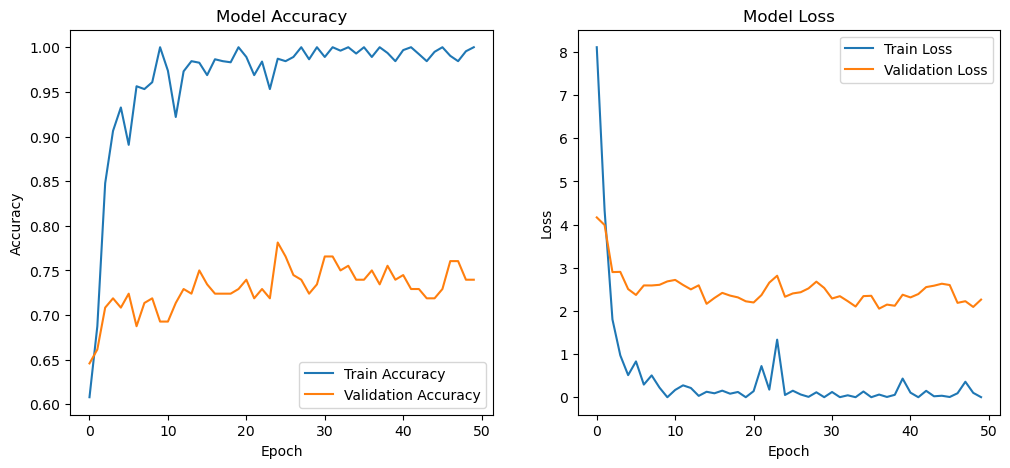

In [10]:
# Визуализация обучения
# Графики точности и потерь
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [11]:
# Загрузка лучшей модели
best_model = tf.keras.models.load_model(FILE_BEST_MODEL)

# Вывод параметров
best_epoch = np.argmax(history.history['val_accuracy']) + 1
print(f"Лучшая эпоха: {best_epoch}")
print(f"Лучшая val_accuracy: {max(history.history['val_accuracy']):.4f}")
print("Архитектура модели:")
best_model.summary()
print(f"Количество слоев: {len(model.layers)}")

Лучшая эпоха: 25
Лучшая val_accuracy: 0.7812
Архитектура модели:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 53,252,933 (203.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 25,692,164 (98.01 MB)

Количество слоев: 23


In [12]:
# Применение модели для предсказаний
def predict_label(image_path):
    # Загрузка и подготовка изображения
    img = image.load_img(image_path, target_size=TARGET_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Предсказание
    prediction = model.predict(img_array)[0][0]
    class_idx = 1 if prediction >= 0.5 else 0
    confidence = prediction if class_idx == 1 else 1 - prediction
    
    return {
        'class': 'unsafe' if class_idx == 1 else 'safe',
        'confidence': float(confidence),
        'prediction': float(prediction)
    }



In [13]:
# Оценка на тестовых данных
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    dir_test,
    target_size=TARGET_SIZE,
    batch_size=32,
    class_mode='binary',
    classes=['safe', 'unsafe'],
    shuffle=False
)

# Загрузка лучшей модели
best_model = tf.keras.models.load_model(FILE_BEST_MODEL)

# Оценка модели
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.2f}')
print(f'Test Loss: {test_loss:.2f}')

# Предсказания для всех тестовых изображений
filenames = test_generator.filenames
start = time.time()
predictions = model.predict(test_generator)
print(f"Time inference: {time.time()-start}")
results = pd.DataFrame({
    'filename': filenames,
    'true_class': ['safe' if not(x) else 'unsafe' for x in test_generator.classes],
    'predicted_class': ['safe' if x < 0.5 else 'unsafe' for x in predictions],
    'confidence': [x if x >= 0.5 else 1-x for x in predictions.flatten()]
})

results.to_csv('predictions_results_'+FILE_BEST_MODEL[:-6]+'.csv', index=False)

Found 200 images belonging to 2 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8527 - loss: 1.9466
Test Accuracy: 0.81
Test Loss: 2.29
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
Time inference: 9.342319011688232


              precision    recall  f1-score   support

      Unsafe       0.84      0.76      0.80       100
        Safe       0.78      0.86      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



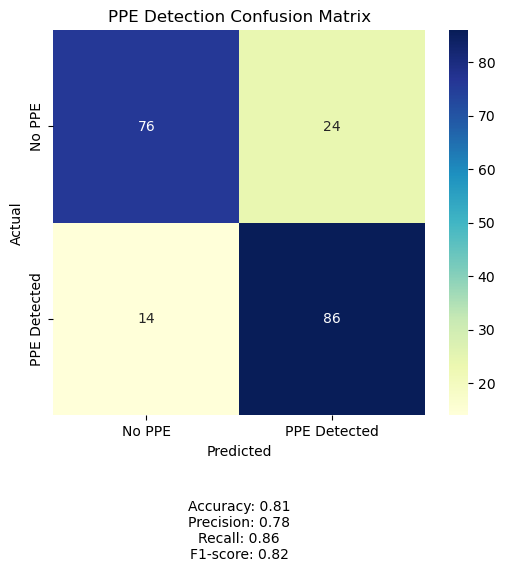

In [14]:
y_true = [int(results['true_class'][i]=='safe') for i in range(len(results))]
result_labels = [int(results['predicted_class'][i]=='safe') for i in range(len(results))]

print(classification_report(y_true, result_labels, 
                           target_names=['Unsafe', 'Safe']))

# Визуализация результатов
# Матрица ошибок
cm = confusion_matrix(y_true, result_labels)

# Визуализация матрицы ошибок
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
           xticklabels=['No PPE', 'PPE Detected'],
           yticklabels=['No PPE', 'PPE Detected'])
plt.title('PPE Detection Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Добавляем метрики прямо на график
plt.text(0.5, -0.3, 
        f'Accuracy: {accuracy_score(y_true, result_labels):.2f}\n'
        f'Precision: {precision_score(y_true, result_labels):.2f}\n'
        f'Recall: {recall_score(y_true, result_labels):.2f}\n'
        f'F1-score: {f1_score(y_true, result_labels):.2f}',
        ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

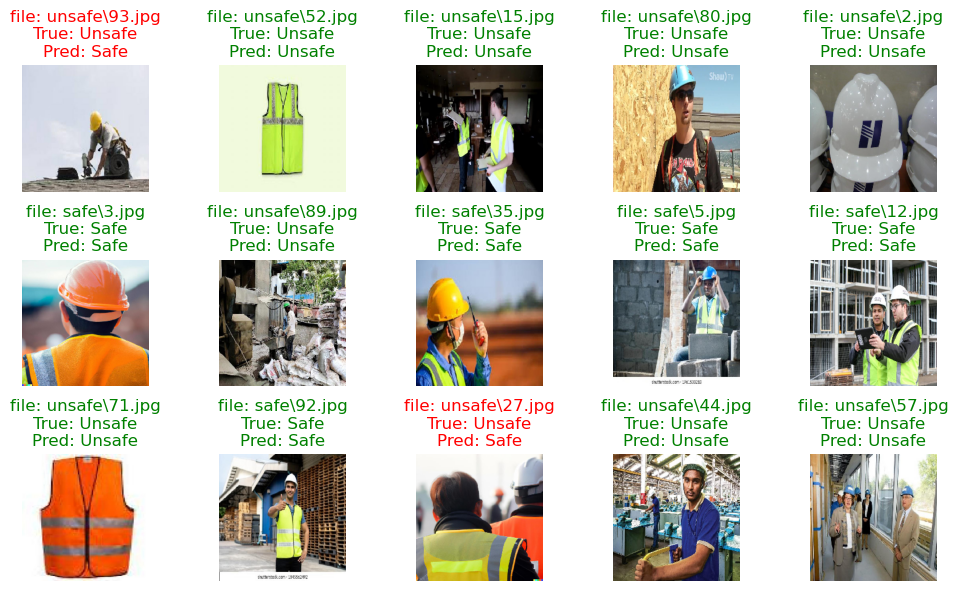

In [16]:
# Получаем предсказания для всех тестовых изображений

# Выбираем 10 случайных индексов
random_indices = np.random.choice(len(results['filename']), 15, replace=False)
# Создаем фигуру
plt.figure(figsize=(10, 6))

for i, idx in enumerate(random_indices):
    # Получаем изображение и метки
    img_path = os.path.join(dir_test, results['filename'][idx])
    img = load_img(img_path, target_size=TARGET_SIZE)  # Ресайз изображений
    img_array = img_to_array(img) / 255.0           # Нормализация [0, 1]
    true_label = y_true[idx]
    pred_label = result_labels[idx]
    
    # Преобразуем метки в текст
    true_class = 'Safe' if true_label == 1 else 'Unsafe'
    pred_class = 'Safe' if pred_label == 1 else 'Unsafe'
    
    # Отображаем изображение
    plt.subplot(3, 5, i+1)
    #if img.max() <= 1.0:
    #    img = (img * 255).astype('uint8')
    plt.imshow(img) #, interpolation='hanning')
    
    # Устанавливаем цвет текста в зависимости от правильности предсказания
    text_color = 'green' if true_label == pred_label else 'red'
    
    # Добавляем подписи
    plt.title(f"file: {results['filename'][idx]}\nTrue: {true_class}\nPred: {pred_class}", color=text_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Predicted class: safe (confidence: 0.98)


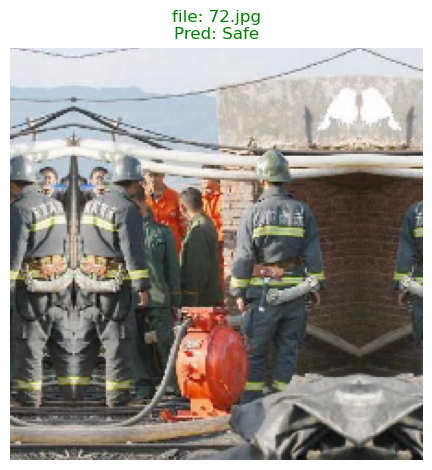

In [17]:
# Пример использования на конкретном изображении
result = predict_label('72.jpg')
print(f"Predicted class: {result['class']} (confidence: {result['confidence']:.2f})")

img = load_img("72.jpg", target_size=TARGET_SIZE)  # Ресайз изображений
img_array = img_to_array(img) / 255.0           # Нормализация [0, 1]

pred_label = result['class']
    
# Преобразуем метки в текст

pred_class = 'Safe' if pred_label == 'safe' else 'Unsafe'
    
# Отображаем изображение
plt.imshow(img) #, interpolation='hanning')
    
# Устанавливаем цвет текста в зависимости от правильности предсказания
text_color = 'green' if pred_label=='safe' else 'red'
    
# Добавляем подписи
plt.title(f"file: 72.jpg\nPred: {pred_class}", color=text_color)
plt.axis('off')

plt.tight_layout()
plt.show()